# Greenest Pixel Composite

For a given analysis tile, use a time series analysis to select greenest pixels for the time window. Based on the Greenest pixel select matching pixels from other bands to use in the derivation of covariates related to plant indicators.

In [1]:
import json
import os
import rasterio as rio
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/projects/pygeotools')
from pygeotools.lib import filtlib, iolib, malib, warplib

from osgeo import gdal


In [2]:
## open json
## parses json file and returns local filepaths
## outputs a listof the local filepaths
def GetBandLists(inJSON, bandnum):
    with open(inJSON) as f:
        response = json.load(f)
    
    BandList = []
    for i in range(len(response.keys())):
        try:
            getBand = response['features'][i]['assets']['SR_B' + str(bandnum) + '.TIF']['href']
            BandList.append(getBand)
        except exception as e:
            print(e)
        
    return BandList


BLUEBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 2)
GREENBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 3)
REDBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 4)
NIRBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 5)
SWIRBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 6)

print("file locations of red bands over ROI = ", REDBands)
print("file locations of nir bands over ROI = ", NIRBands)


file locations of red bands over ROI =  ['/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180910_20200830_02_T1/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031028_20180910_20200830_02_T1/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180825_20200831_02_T1/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_032028_20180816_20200831_02_T1/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B4.TIF']
file locations of nir bands over ROI =  ['/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180910_20200830_02_T1/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031028_20180910_20200830_02_T1/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180825_20200831_02_T1/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/LC08

In [ ]:
## WRITE TMP FILES TO DISK.ONLY DO ONCE. 
## FILES ARE IN: '/projects/bobafett/LandsatComposites/'

## Use pygeotools to warp them all to the same extent
## inputs the list of files from above
## output is a new list of warped objects the size of the entire extent

def WarpRasters(filelist):
    #outWarp = warplib.memwarp_multi_fn(filelist, extent='union', res=30, t_srs='first', r='near')
    outWarp = warplib.diskwarp_multi_fn(filelist, outdir='/projects/bobafett/LandsatComposites/', extent='union', res=30, t_srs='first', r='near')
    return outWarp

print("Warping rasters to same res/extent/proj")
B_list = WarpRasters(BLUEBands)
G_list = WarpRasters(GREENBands)
R_list = WarpRasters(REDBands)
NIR_list = WarpRasters(NIRBands)
SWIR_list = WarpRasters(SWIRBands)


print("finished")

# Get geotransform variable for later use
GeoTForm = R_list[0].GetGeoTransform()



In [3]:
## read all bandas as masked arrays
## read each object in each list as a masked array 

def MaskArrays(file):
    print(file)
    with rio.open(file, 'r') as f:
        band = f.read(1, masked=True)
    return band.astype(float)


outDir = '/projects/bobafett/LandsatComposites/'

def GetFiles(file, outDir):
    base = os.path.basename(file).replace('.TIF','_warp.tif')
    outfile = os.path.join(outDir, base)
    
    return outfile


print(REDBands)

redFiles = [GetFiles(x, outDir) for x in REDBands]
NIRFiles = [GetFiles(x, outDir) for x in NIRBands]
blueFiles = [GetFiles(x, outDir) for x in BLUEBands]
greenFiles = [GetFiles(x, outDir) for x in GREENBands]
SWIRFiles = [GetFiles(x, outDir) for x in SWIRBands]

redFiles.sort()
NIRFiles.sort()
blueFiles.sort()
greenFiles.sort()
SWIRFiles.sort()


print(redFiles)
print(SWIRFiles)


print("finished")



['/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180910_20200830_02_T1/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031028_20180910_20200830_02_T1/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180825_20200831_02_T1/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_032028_20180816_20200831_02_T1/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B4.TIF']
['/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B4_warp.tif', '/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B4_warp.tif', '/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B4_warp.tif', '/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B4_warp.tif']
['/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B6_warp.tif', '/projects/bo

In [4]:
## create NDVI layers
## Loopsover lists of bands and calculates NDVI
## creates a new list of NDVI images, one per input scene


def CreateNDVIstack(REDfile, NIRfile):
    print("Creating NDVI layer ")
    NIRarr = MaskArrays(NIRfile)
    REDarr = MaskArrays(REDfile) 
    return np.ma.array((NIRarr-REDarr)/(NIRarr+REDarr))

# tmp hack to subset list
redFiles = [redFiles[x] for x in [0,1,3]]
NIRFiles = [NIRFiles[x] for x in [0,1,3]]
greenFiles = [greenFiles[x] for x in [0,1,3]]
blueFiles = [blueFiles[x] for x in [0,1,3]]
SWIRFiles = [SWIRFiles[x] for x in [0,1,3]]


NDVIstack = [CreateNDVIstack(redFiles[i],NIRFiles[i]) for i in range(len(redFiles))]
print('finished')


Creating NDVI layer 
/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B4_warp.tif
Creating NDVI layer 
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B4_warp.tif
Creating NDVI layer 
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B4_warp.tif
finished


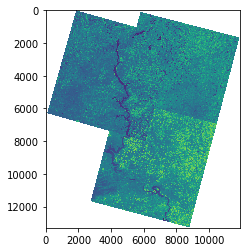

In [5]:
#print(NDVIstack[0])

plt.imshow(NDVIstack[0])
plt.imshow(NDVIstack[1])
plt.imshow(NDVIstack[2])


-0.2490415695707735
0.8565529508925736
(3, 13301, 11871)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


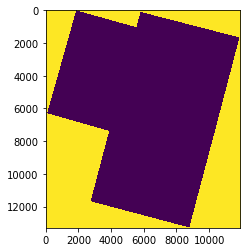

In [6]:
print(np.min(NDVIstack))
print(np.max(NDVIstack))
print(np.shape(NDVIstack))

MaxNDVI = np.ma.max(np.ma.array(NDVIstack),axis=0)
BoolMask = np.ma.getmask(MaxNDVI)

del MaxNDVI

plt.imshow(BoolMask)
print(BoolMask)

(13301, 11871)


Text(0, 0.5, '$\\bf{Image Location}$')

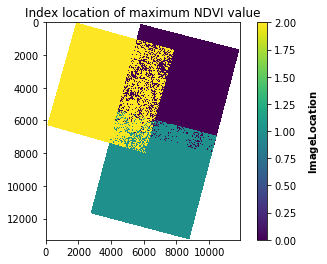

In [7]:
## get the index positions of the max NDVI value
## Get the argmax index positions from the stack of NDVI images

#Avoid slice of all nan
#NDVIstack[NDVIstack==np.nan] = 0

NDVIstack = np.ma.array(NDVIstack)
NDVImax = np.nanargmax(NDVIstack,axis=0)
print(np.shape(NDVImax))
## create a tmp array (binary mask) of the same input shape
NDVItmp = np.ma.zeros(NDVIstack.shape, dtype=bool)

## for each dimension assign the index position (flattens the array to a LUT)
for i in range(np.shape(NDVIstack)[0]):
    NDVItmp[i,:,:]=NDVImax==i
    

plt.imshow(np.ma.masked_array(NDVImax, BoolMask), cmap='viridis')
plt.title("Index location of maximum NDVI value")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{Image Location}$",  labelpad=10, rotation=90)  
#plt.savefig('/projects/bobafett/LandsatComposites/Landsat_MaxNDVIIdx.png', format='PNG')

In [8]:
## Return Red value based on NDVI max index position

# insert the bands as arrays (made earlier)
## creates a single layer by using the binary mask
## and a sum function to collapse n-dims to 2-dims
def CollapseBands(inArr, NDVItmp, BoolMask):
    inArr = np.ma.masked_equal(inArr, 0)
    inArr[np.logical_not(NDVItmp)]=0 
    compImg = np.ma.masked_array(inArr.sum(0), BoolMask)
    
    return compImg

def CreateComposite(file_list, NDVItmp, BoolMask):
    MaskedFiles = [MaskArrays(file_list[i]) for i in range(len(file_list))]
    Composite=CollapseBands(MaskedFiles, NDVItmp, BoolMask)
    return Composite




In [9]:
RedComp = CreateComposite(redFiles, NDVItmp, BoolMask)
BlueComp = CreateComposite(blueFiles, NDVItmp, BoolMask)
GreenComp = CreateComposite(greenFiles, NDVItmp, BoolMask)

/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B4_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B4_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B4_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B2_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B2_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B2_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B3_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B3_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B3_warp.tif


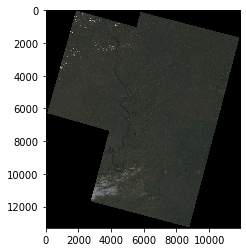

In [10]:
def norm(band):
    band_min, band_max = band.min(), band.max()
    scale = ((band - band_min)/(band_max - band_min))*255
    return scale.astype(np.ubyte)

def RGBstack(b2, b3, b4):
    b2 = norm(b2)
    b3 = norm(b3)
    b4 = norm(b4)

    rgb = np.ma.dstack((b4,b3,b2))

    return rgb

rgb = RGBstack(BlueComp,GreenComp,RedComp)

plt.imshow(rgb)

# hack to free up memory
del rgb, BlueComp, GreenComp
#del BlueComp, GreenComp, rgb
#cbar1.ax.set_ylabel(r"$\bf{Reflectance}$",  labelpad=10, rotation=90)  
#plt.savefig('/projects/bobafett/LandsatComposites/Landsat_RGBComposite.png', format='PNG')

In [11]:
## Create Indices of interest from new composites
NIRComp = CreateComposite(NIRFiles, NDVItmp, BoolMask)


/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B5_warp.tif
calculating Red edge (Simple ratio)...


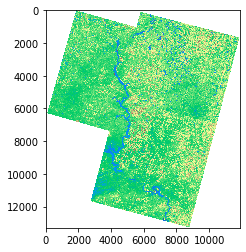

In [12]:
plt.imshow(np.ma.masked_array(REComp, BoolMask), cmap="terrain")

In [ ]:
##### STOP HERE #######


## Stack bands to write out RGB
ReflectanceStack = np.array([BlueComp, GreenComp, RedComp, NIRComp, SWIRComp])
IndicesStack = np.array([NDVIComp, SAVIComp, REComp, EVIComp, NDMIComp])
print(np.min(NDVIComp))
print(np.max(NDVIComp))

In [ ]:
# Write arrays to multiband image

from osgeo import gdal, osr
import os
import io
import numpy as np

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,driver,outtype, names):

    bands = array.shape[0]
    print('number of bands: ', bands)
    rows = array.shape[1]
    cols = array.shape[2]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    driver = gdal.GetDriverByName(driver)
    #Here is where I assign three bands to the raster with int 3
    option=['COMPRESS=LZW']
    outRaster = driver.Create(newRasterfn, cols, rows, bands, outtype, options=option)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    #outband = outRaster.GetRasterBand(1)
    #outband.WriteArray(array)
    for band in range(bands):
        print("Processing band :", names[band])
        outRaster.SetDescription(names[band])
        outRaster.GetRasterBand(band+1).WriteArray( array[band, :, :] )

    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    print('Assign spatial ref')
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    print('writing out')
    outRaster.FlushCache()
    print('complete')
    
    return outRaster

ReflectanceOutput = "/projects/bobafett/LandsatComposites/LS8_GC_2018_refl.tif"
IndicesOutput = "/projects/bobafett/LandsatComposites/LS8_GC_2018_idx.tif"

geotransform = B_list[0].GetGeoTransform()
rasterOrigin=[geotransform[0], geotransform[3]]
pixelW = geotransform[1]
pixelH = geotransform[5]

#outRaster = array2raster(ReflectanceOutput,rasterOrigin, pixelW, pixelH, ReflectanceStack, 'GTiff', gdal.GDT_UInt16, ['Blue', 'Green', 'Red', 'NIR', 'SWIR'])
outRaster = array2raster(IndicesOutput,rasterOrigin, pixelW, pixelH, IndicesStack, 'GTiff', gdal.GDT_Int16, ['NDVI', 'SAVI', "RedEdge", "EVI", "NDMI"])
print('finished')